In [3]:
from typing import TypedDict,List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

In [4]:
class State(TypedDict):
  text: str
  classification: str
  entities: List[str]
  summary: str

In [4]:
from langchain_groq import ChatGroq

In [7]:
llm = ChatGroq(
    temperature=0,
    groq_api_key = "",
    model_name = "llama-3.3-70b-versatile"
)


In [8]:
def classification_node(state: State):
  "Research, News, Blog or Others"
  prompt = PromptTemplate(
      input_variable = ["text"],
      template = "Classify the following text into one of the categories: News, Blog, Research , or Other. \n\nText:{text}\n\nCategory:"
  )
  message = HumanMessage(content = prompt.format(text = state["text"]))
  classification = llm.invoke([message]).content.strip()
  return {"classification":classification}

In [10]:
def entity_extraction_node(state: State):
  prompt = PromptTemplate(
      input_variables=["text"],
      template = "Extract all the entities (Person, Organization, Location) from the following text. Provide the result as a comma separated list. \n\nText:{text}\n\nEntities:"
  )
  message = HumanMessage(content = prompt.format(text = state["text"]))
  entities = llm.invoke([message]).content.strip().split(", ")
  return {"entities": entities}

In [12]:
def summarization_node(state: State):
  prompt = PromptTemplate(
      input_variable = ["text"],
      template = "Summarize the following text in one short sentence. \n\nText:{text}\n\nSummary:"
  )
  message = HumanMessage(content = prompt.format(text = state["text"]))
  summary = llm.invoke([message]).content.strip()
  return {"summary":summary}

In [13]:
workflow = StateGraph(State)

workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction_node", entity_extraction_node)
workflow.add_node("summarization_node", summarization_node)

workflow.set_entry_point("classification_node")

workflow.add_edge("classification_node", "entity_extraction_node")
workflow.add_edge("entity_extraction_node", "summarization_node")
workflow.add_edge("summarization_node", END)

app = workflow.compile()

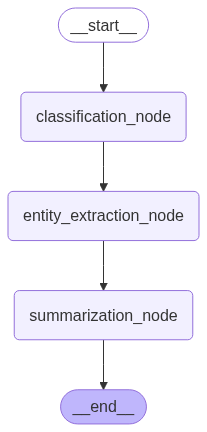

In [14]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [15]:
SAMPLE_TEXT = """You Need Much Less Memory than Time
Just as I was complaining that we haven't seen many surprising breakthroughs in complexity recently, we get an earthquake of a result to start the year, showing that all algorithms can be simulated using considerable less memory than the time of the original algorithm. You can reuse space (memory) but you can't reuse time, and this new result from Ryan Williams in an upcoming STOC paper provides the first stark difference.

DTIME(
) 
 DSPACE(
)

This is a vast improvement on the previous best known simulation, the classic 1977 Hopcroft-Paul-Valiant paper showing

DTIME(
) 
 DSPACE(
)

only slightly lower than the trivial 
 bound. Williams gets a huge near quadratic improvement that will go down as a true classic complexity theorem. Note that the space simulation does not maintain the time bound.

Williams' proof relies on a space-efficient tree evaluation algorithm by James Cook and Ian Mertz from last year's STOC conference. Cook and Mertz's algorithm builds on earlier work on catalytic computing, highlighted in a recent Quanta article. 

Let me give an highly overly simplified view of the combined proof.

A 
 time Turing machine uses at most that much space on its tapes. Split the tapes into 
 segments of size 
. Using the fact that it takes 
 time to cross an entire segment, Williams with some clever tricks models acceptance of the Turing machines as a circuit of bounded degree and depth 
, where the wires carry the contents of the size 
 segments at various times in the computation. 

Williams then applies the tree evaluation algorithm of Cook and Mertz. Cook and Mertz use finite fields to encode these segments as a combination of registers of size 
 and show how to compute the value of each node of the tree using only 
 space for the local computation plus needing to only remember a constant number of registers while reusing the rest of the space when recursively computing the tree. It's pretty magical how they manage to make it all work. 

It's worth going through the proof yourself. I recommend Sections 3.1 and Footnote 6 in Williams' paper (a slightly weaker space bound but much simpler) and Sections 2-4 of the Cook-Mertz paper. Oded Goldreich has an alternative exposition of the Cook-Mertz algorithm and proof.

Williams' theorem works for multitape Turing machines and oblivious random-access machines, where the queries to the memory are fixed in advance. He shows how to use this result to compute the output a circuit of size 
 using nearly 
 space. Fully general random access machines remains open, as does nondeterministic and other models of computation (random, quantum, etc).

In 1986 my advisor Mike Sipser gave the first hardness vs randomness result, showing roughly that if there were problems that took time 
 but could not be solved in space 
 on multi-tape Turing machines then RP = P. Williams' theorem kills this assumption though we've developed weaker assumptions since. 

Moving forward, can we push Williams' result to get a simulation in space 
 for 
. A simulation for all 
 would separate P from PSPACE. Even a slight improvement would have applications for alternating time. Maybe try to use the Cook-Mertz techniques directly in the Turing machine simulation instead of going through computation trees.

Read sections 4 and 5 of Williams' paper for some further consequences and challenges for further improvements. """

state_input = {"text": SAMPLE_TEXT}
result = app.invoke(state_input)

In [16]:
print("Classification :", result["classification"])
print("\nEntities :", result["entities"])
print("\nSummary :", result["summary"])

Classification : Category: Blog 

The text appears to be a blog post due to its informal and conversational tone, as well as the presence of personal opinions and anecdotes. The author is discussing a recent research result and providing an overview of the proof, but the language used is not as formal as one would expect in a research paper. Additionally, the text includes personal references, such as the author's advisor, and encourages readers to explore certain sections of the research paper, which is typical of a blog post.

Entities : ['Ryan Williams', 'James Cook', 'Ian Mertz', 'Hopcroft', 'Paul', 'Valiant', 'Oded Goldreich', 'Mike Sipser', 'Quanta', 'STOC.']

Summary : Ryan Williams has made a breakthrough in complexity theory, proving that all algorithms can be simulated using significantly less memory than their original time complexity.
